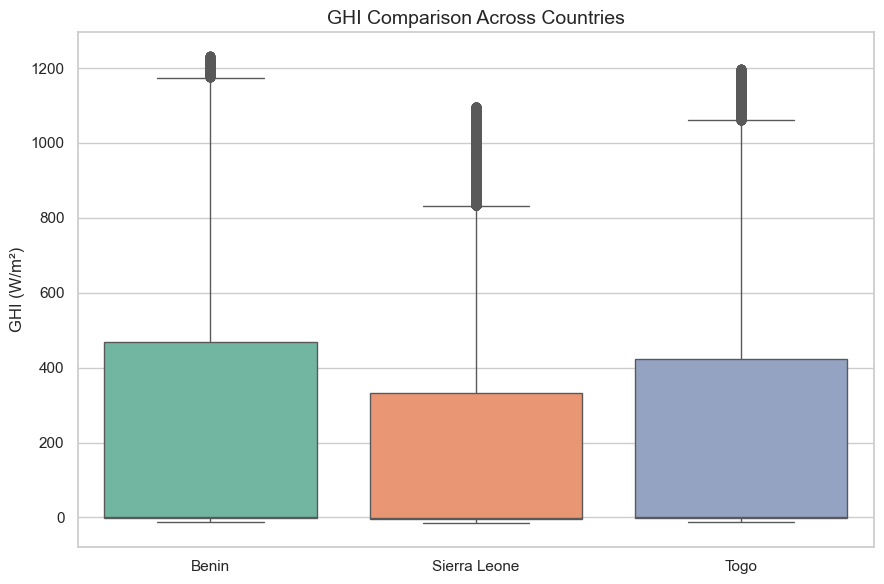

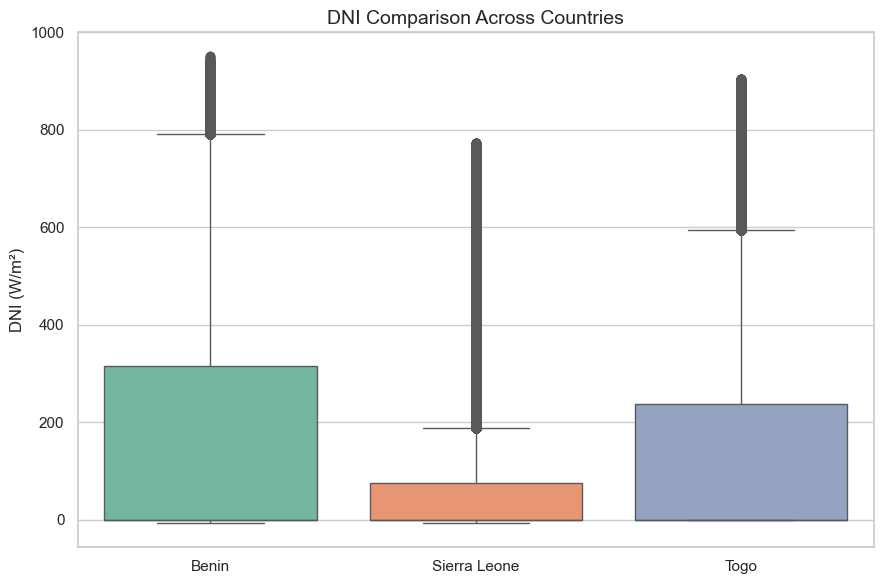

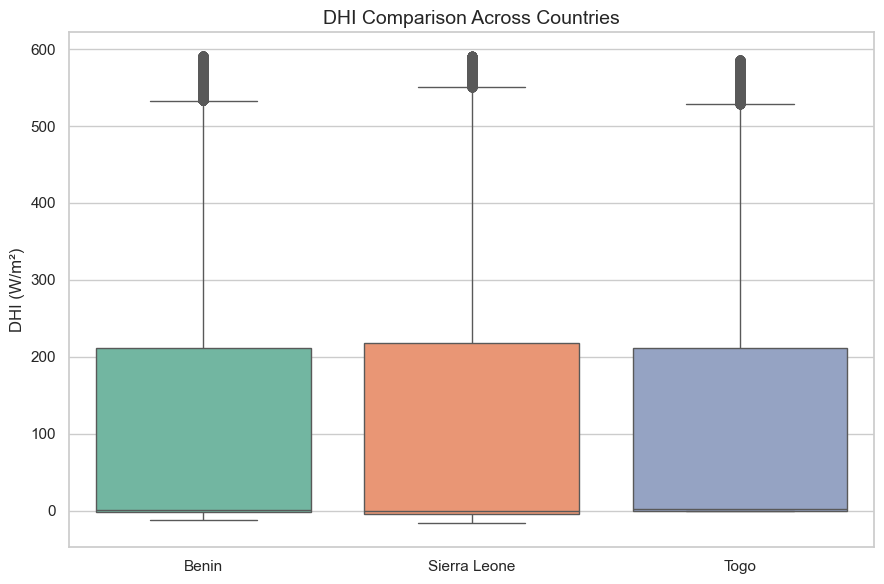


=== Summary Table ===
     Country   GHI_mean  GHI_median    GHI_std  GHI_min  GHI_max   DNI_mean  DNI_median    DNI_std  DNI_min  DNI_max   DHI_mean  DHI_median    DHI_std  DHI_min  DHI_max
       Benin 236.234508         0.7 328.288787    -11.1   1233.0 166.896673        -0.1 262.081997     -7.8    952.3 111.656477         0.5 153.099749    -12.6    591.4
Sierra Leone 185.000024        -0.4 279.019460    -15.9   1097.0 104.128943        -0.1 200.954182     -7.8    772.3 108.104278        -0.6 153.691835    -16.7    590.5
        Togo 223.859675         0.5 317.306277    -12.7   1198.0 147.975931         0.0 247.683690      0.0    904.1 112.781249         1.5 151.571744      0.0    586.0

=== Statistical Significance Testing ===
ANOVA p-value for GHI: 0.00000
Kruskal-Wallis p-value for GHI: 0.00000

=== Key Observations ===
- Benin has the highest average GHI, making it ideal for solar investment.
- Benin has the most variable DNI, indicating inconsistent direct sunlight.
- Togo show

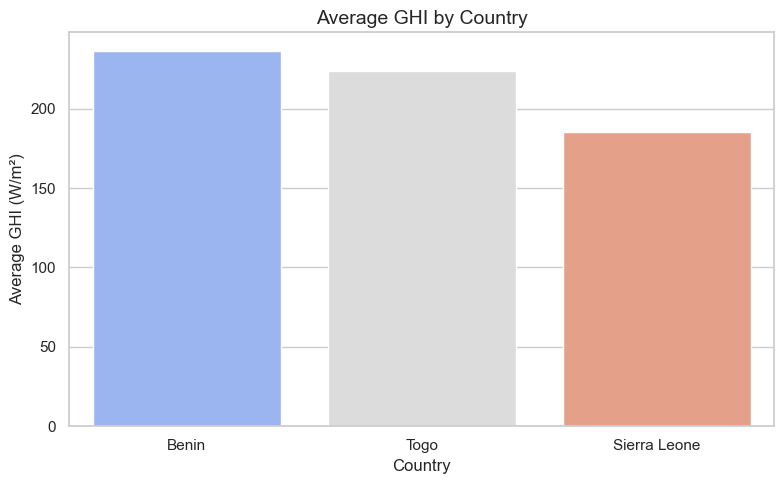

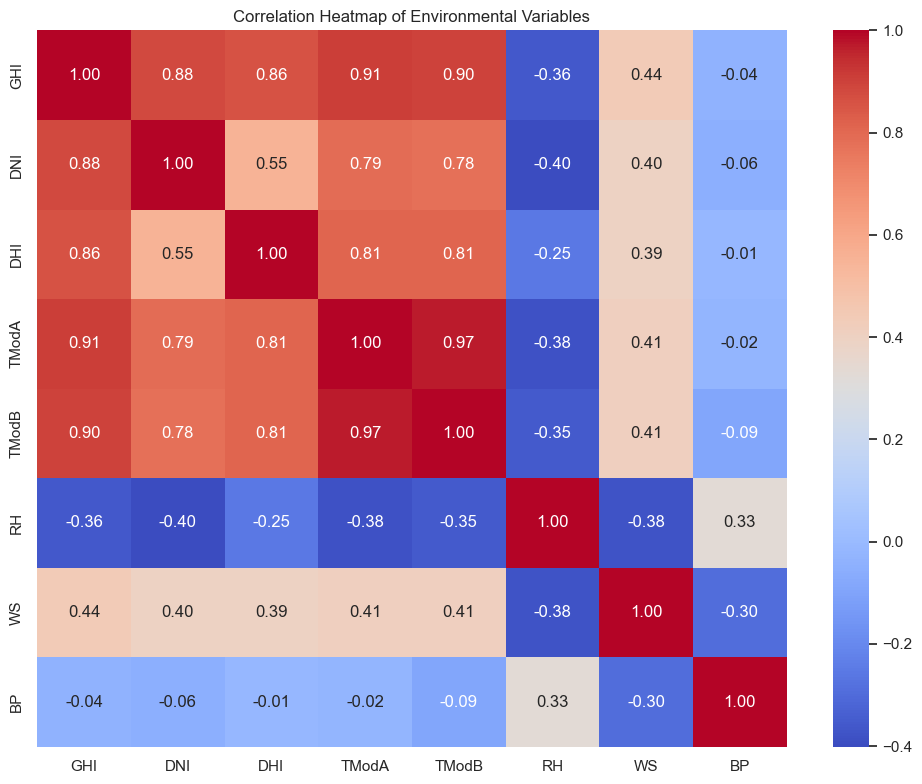

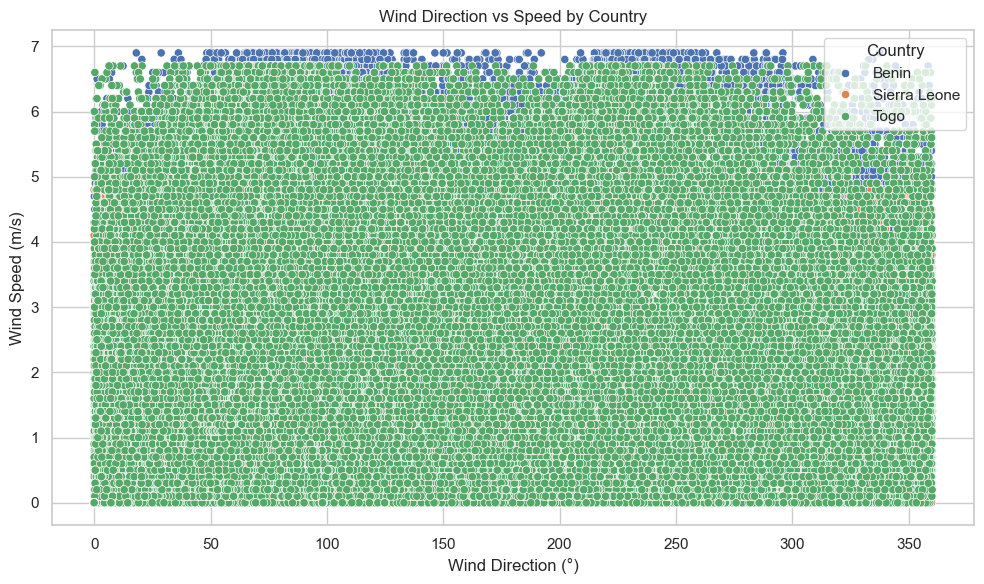

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
import os

import warnings
warnings.filterwarnings('ignore')


# === Setup ===
os.makedirs("plots", exist_ok=True)
sns.set(style="whitegrid")

# === Load Cleaned Data ===
def load_data():
    countries = {
        'Benin': 'data/benin_clean.csv',
        'Sierra Leone': 'data/sierra_leone_clean.csv',
        'Togo': 'data/togo_clean.csv'
    }
    dfs = []
    for name, path in countries.items():
        df = pd.read_csv(path)
        df['Country'] = name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_all = load_data()

# === Helper to show and save plots ===
def show_and_save_plot(filename):
    plt.tight_layout()
    plt.savefig(f'plots/{filename}')
    plt.show()
    plt.close()

# === Plot Boxplots ===
def plot_boxplots(df, metrics):
    for metric in metrics:
        plt.figure(figsize=(9, 6))
        sns.boxplot(x='Country', y=metric, data=df, palette='Set2')
        plt.title(f'{metric} Comparison Across Countries', fontsize=14)
        plt.ylabel(f'{metric} (W/m²)')
        plt.xlabel('')
        show_and_save_plot(f'boxplot_{metric.lower()}.png')

# === Generate Summary Stats ===
def generate_summary(df, metrics):
    summary = df.groupby('Country')[metrics].agg(['mean', 'median', 'std', 'min', 'max'])
    summary.columns = ['_'.join(col) for col in summary.columns]
    return summary.reset_index()

# === Statistical Tests ===
def perform_tests(df, column):
    groups = [df[df['Country'] == c][column].dropna() for c in df['Country'].unique()]
    anova_p = f_oneway(*groups).pvalue
    kruskal_p = kruskal(*groups).pvalue
    return anova_p, kruskal_p

# === Correlation Heatmap ===
def correlation_analysis(df):
    corr_df = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'RH', 'WS', 'BP']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Environmental Variables')
    show_and_save_plot('correlation_heatmap.png')

# === Wind Direction vs Speed Plot ===
def plot_wind_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='WD', y='WS', hue='Country')
    plt.title('Wind Direction vs Speed by Country')
    plt.xlabel('Wind Direction (°)')
    plt.ylabel('Wind Speed (m/s)')
    show_and_save_plot('wind_direction_vs_speed.png')

# === Temperature vs RH and GHI ===
def plot_temp_humidity_effects(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='RH', y='Tamb', hue='Country')
    plt.title('Relative Humidity vs Ambient Temperature')
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('Ambient Temperature (°C)')
    show_and_save_plot('humidity_vs_temp.png')

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='RH', y='GHI', hue='Country')
    plt.title('Relative Humidity vs GHI')
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('GHI (W/m²)')
    show_and_save_plot('humidity_vs_ghi.png')

# === Average GHI Bar Chart ===
def plot_avg_ghi(df):
    avg_ghi = df.groupby('Country')['GHI'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=avg_ghi.index, y=avg_ghi.values, palette='coolwarm')
    plt.title('Average GHI by Country', fontsize=14)
    plt.ylabel('Average GHI (W/m²)')
    plt.xlabel('Country')
    show_and_save_plot('bar_avg_ghi.png')

# === Key Observations ===
def print_observations(summary):
    print("\n=== Key Observations ===")
    top_ghi = summary.loc[summary['GHI_mean'].idxmax(), 'Country']
    highest_dni_std = summary.loc[summary['DNI_std'].idxmax(), 'Country']
    lowest_dhi_var = summary.loc[summary['DHI_std'].idxmin(), 'Country']
    print(f"- {top_ghi} has the highest average GHI, making it ideal for solar investment.")
    print(f"- {highest_dni_std} has the most variable DNI, indicating inconsistent direct sunlight.")
    print(f"- {lowest_dhi_var} shows consistent DHI, beneficial for diffuse solar systems.")

# === Main Execution ===
if __name__ == '__main__':
    metrics = ['GHI', 'DNI', 'DHI']
    plot_boxplots(df_all, metrics)
    summary_stats = generate_summary(df_all, metrics)

    print("\n=== Summary Table ===")
    print(summary_stats.to_string(index=False))

    anova_p, kruskal_p = perform_tests(df_all, 'GHI')
    print("\n=== Statistical Significance Testing ===")
    print(f"ANOVA p-value for GHI: {anova_p:.5f}")
    print(f"Kruskal-Wallis p-value for GHI: {kruskal_p:.5f}")

    print_observations(summary_stats)
    plot_avg_ghi(df_all)
    correlation_analysis(df_all)
    plot_wind_distribution(df_all)
    plot_temp_humidity_effects(df_all)

